In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer

from longitudinal.settings.constants import DATA_PATH

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data (replace with your actual file paths)
gen1_data = pd.read_csv(DATA_PATH + "gen1_train_comp_final.csv")
gen2_data = pd.read_csv(DATA_PATH + "gen2_train_comp_final.csv")
gen1_data.head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
0,774,F,0.10,56.961812
1,774,F,0.25,64.826190
2,774,F,0.50,74.340764
3,774,F,0.75,79.747338
4,774,F,1.00,84.092569


In [3]:
print(gen1_data.gen1_id.nunique())
gen1_data.isnull().sum()

101


gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                  310
dtype: int64

In [4]:
gen2_data.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,3012,M,mother,636,0.10,56.251625,4.636903
1,3012,M,mother,636,0.25,64.491579,NaN
2,3012,M,mother,636,0.50,70.465927,NaN
3,3012,M,mother,636,0.75,73.992677,NaN
4,3012,M,mother,636,1.00,79.343537,NaN


In [5]:
print(gen2_data.gen2_id.nunique())
gen2_data.isnull().sum()

192


gen2_id                     0
sex_assigned_at_birth       0
study_parent_sex            0
study_parent_id_new         0
AgeGr                       0
SHgt_cm                   512
Wgt_kg                   2045
dtype: int64

In [6]:
merged_data = pd.merge(gen2_data, gen1_data, how='left', left_on="study_parent_id_new", right_on="gen1_id", suffixes=("_child", "_parent"))
print(merged_data.shape)
merged_data.head()

(120494, 11)


,gen2_id,sex_assigned_at_birth_child,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm_child,Wgt_kg,gen1_id,sex_assigned_at_birth_parent,age,SHgt_cm_parent
0,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.10,53.818812
1,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.25,61.276841
2,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.50,68.828343
3,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.75,75.452930
4,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,1.00,77.834870


In [7]:
merged_data.groupby(["gen2_id"]).apply(lambda row: len(set(row["study_parent_sex"]))).value_counts()

1    188
2      4
Name: count, dtype: int64

In [8]:
merged_data.isnull().sum()

gen2_id                             0
sex_assigned_at_birth_child         0
study_parent_sex                    0
study_parent_id_new                 0
AgeGr                               0
SHgt_cm_child                   14407
Wgt_kg                          58045
gen1_id                           902
sex_assigned_at_birth_parent      902
age                               902
SHgt_cm_parent                  11088
dtype: int64

In [9]:
merged_data.describe()

,gen2_id,study_parent_id_new,AgeGr,SHgt_cm_child,Wgt_kg,gen1_id,age,SHgt_cm_parent
count,120494.000000,120494.000000,120494.000000,106087.000000,62449.000000,119592.000000,119592.000000,109406.000000
mean,2664.237904,570.137484,7.140909,118.678885,38.017027,570.629139,10.350000,135.421024
std,100.941558,117.840982,5.646012,37.609424,16.534558,117.209966,6.323429,38.823067
min,1332.000000,262.000000,0.100000,49.896709,4.636903,370.000000,0.100000,50.627457
25%,2579.000000,485.000000,1.500000,84.027467,24.140498,485.000000,4.750000,105.983143
50%,2664.000000,569.000000,6.500000,121.187800,34.147985,569.000000,11.250000,146.424900
75%,2745.000000,663.000000,12.000000,151.362557,50.053202,663.000000,15.625000,166.664428
max,3012.000000,774.000000,18.000000,196.140713,112.812058,774.000000,20.000000,197.081343


In [10]:
merged_data['SHgt_cm_parent'] = (
    merged_data.groupby("gen1_id")['SHgt_cm_parent']
    .apply(lambda x: x.interpolate(method='linear'))
    .reset_index(level=0, drop=True)
    .bfill()
)

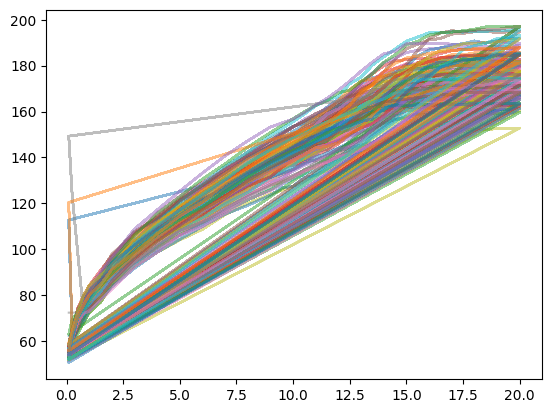

In [11]:
for id in merged_data.gen1_id.unique():
    temp = merged_data[merged_data.gen1_id == id]
    plt.plot(temp["age"].values, temp["SHgt_cm_parent"].values, alpha=0.5)

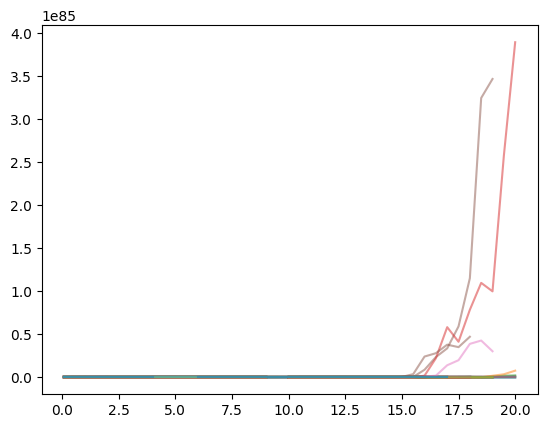

In [12]:
for id in gen1_data.gen1_id.unique():
    temp = gen1_data[gen1_data.gen1_id == id]
    plt.plot(temp["age"].values, np.exp(temp["SHgt_cm"].values), alpha=0.5)

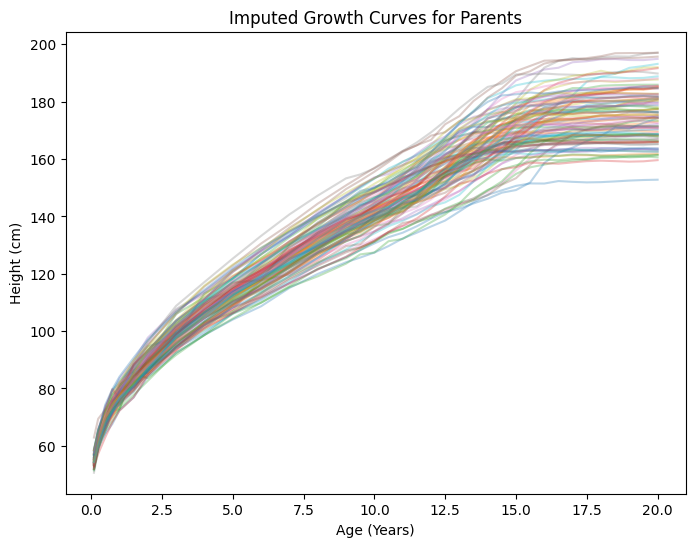

In [18]:
df = gen1_data.copy() 

def linear_interpolation_for_specific_range(group):
    """Applies linear interpolation only to the 9-10 year age range."""
    mask = (group['age'] >= 9)
    group.loc[mask, 'SHgt_cm'] = group.loc[mask, 'SHgt_cm'].interpolate(method='polynomial', order=2)
    return group

df = df.groupby("gen1_id", group_keys=False).apply(linear_interpolation_for_specific_range).reset_index(drop=True)

knn_imputer = KNNImputer(n_neighbors=5, weights="uniform") 
knn_data = df[['age', 'SHgt_cm']]
df['SHgt_cm_parent'] = knn_imputer.fit_transform(knn_data)[:, 1]

mean_height_by_age = df.groupby("age")['SHgt_cm_parent'].transform(lambda x: x.fillna(x.mean()))
df['SHgt_cm_parent'] = df['SHgt_cm_parent'].fillna(mean_height_by_age)

parent_counts = df.groupby("gen1_id")['SHgt_cm_parent'].count()
valid_parents = parent_counts[parent_counts >= 3].index
df = df[df['gen1_id'].isin(valid_parents)]

plt.figure(figsize=(8,6))
for parent_id, group in df.groupby("gen1_id"):
    plt.plot(group["age"], group["SHgt_cm_parent"], alpha=0.3)

plt.xlabel("Age (Years)")
plt.ylabel("Height (cm)")
plt.title("Imputed Growth Curves for Parents")
plt.show()

In [15]:
df.isna().sum()

gen1_id                   0
sex_assigned_at_birth     0
age                       0
SHgt_cm                  27
SHgt_cm_parent            0
dtype: int64

In [29]:
np.exp(group["SHgt_cm_parent"])

0     5.472689e+24
1     1.424480e+28
2     1.931005e+32
3     4.303572e+34
4     3.318475e+36
5     2.433215e+39
6     1.331115e+42
7     2.007295e+46
8     4.840045e+49
9     9.757103e+52
10    1.055173e+56
11    2.959655e+58
12    6.683903e+60
13    1.177563e+63
14    4.609438e+64
15    1.450150e+65
16    1.343527e+66
17    1.866129e+67
18    2.157196e+68
19    2.814121e+70
20    6.190388e+72
21    8.329134e+74
22    4.366992e+76
23    1.397995e+78
24    1.310838e+79
25    1.987707e+79
26    3.669263e+79
27    2.448787e+79
28    5.242234e+79
29    7.621572e+79
30    8.078592e+79
31    8.563017e+79
32    1.345843e+80
33    2.115253e+80
34    1.944256e+80
35    1.787083e+80
Name: SHgt_cm_parent, dtype: float64

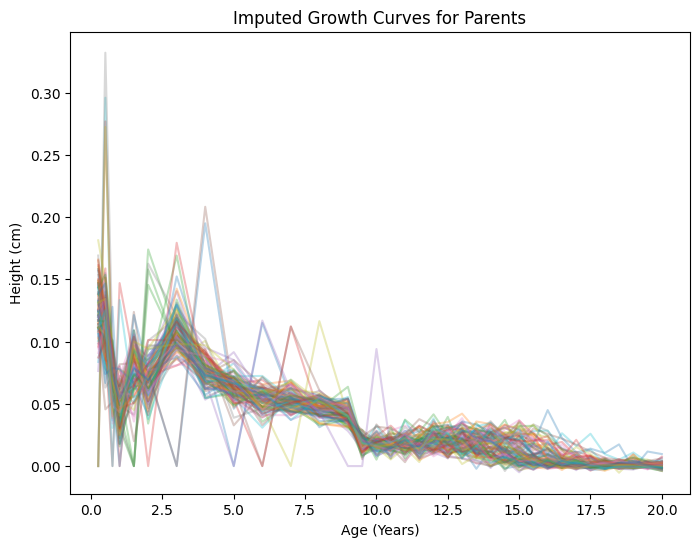

In [16]:
plt.figure(figsize=(8,6))
for parent_id, group in df.groupby("gen1_id"):
    plt.plot(group["age"], group["SHgt_cm"].pct_change(), alpha=0.3)

plt.xlabel("Age (Years)")
plt.ylabel("Height (cm)")
plt.title("Imputed Growth Curves for Parents")
plt.show()

In [18]:
df.head().isna().count()

gen1_id                  5
sex_assigned_at_birth    5
age                      5
SHgt_cm                  5
SHgt_cm_parent           5
dtype: int64

In [22]:
df[df["SHgt_cm_parent"].isna()]

,gen1_id,sex_assigned_at_birth,age,SHgt_cm,SHgt_cm_parent


In [5]:
gen1_df = pd.read_csv(DATA_PATH + "gen1_train_comp_final.csv")
gen2_df = pd.read_csv(DATA_PATH + "gen2_train_comp_final.csv")

# Pivot gen1_df to create wide-format parent height trajectories
gen1_pivot = gen1_df.pivot(index="gen1_id", columns="age", values="SHgt_cm").reset_index()

# Rename columns for clarity (age as suffix)
gen1_pivot.columns = ["gen1_id"] + [f"parent_height_age_{int(age)}" for age in gen1_pivot.columns[1:]]

# Merge parental sex information
gen1_meta = gen1_df[["gen1_id", "sex_assigned_at_birth"]].drop_duplicates()
gen1_pivot = gen1_pivot.merge(gen1_meta, on="gen1_id", how="left")

# Pivot gen2_df to create wide-format child height trajectories
gen2_pivot = gen2_df.pivot(index=["gen2_id", "study_parent_sex", "study_parent_id_new"], 
                            columns="AgeGr", values="SHgt_cm").reset_index()

# Rename columns for clarity
gen2_pivot.columns = ["gen2_id", "study_parent_sex", "study_parent_id_new"] + [f"child_height_age_{int(age)}" for age in gen2_pivot.columns[3:]]

# Merge parental height data into child dataset
merged_df = gen2_pivot.merge(gen1_pivot, left_on="study_parent_id_new", right_on="gen1_id", how="left")

# Separate mother and father data
mother_df = merged_df[merged_df["study_parent_sex"] == "mother"].drop(columns=["study_parent_sex", "gen1_id"])
father_df = merged_df[merged_df["study_parent_sex"] == "father"].drop(columns=["study_parent_sex", "gen1_id"])

# Rename parental columns for clarity
mother_df = mother_df.rename(columns=lambda x: x.replace("parent", "mother") if "parent" in x else x)
father_df = father_df.rename(columns=lambda x: x.replace("parent", "father") if "parent" in x else x)

# Merge mother and father data on child ID
final_df = mother_df.merge(father_df, on="gen2_id", suffixes=("_mother", "_father"), how="outer")

# Display the structured training DataFrame
# tools.display_dataframe_to_user(name="Structured Training Data", dataframe=final_df)

final_df.head()

,gen2_id,study_mother_id_new,child_height_age_0_mother,child_height_age_0_mother,child_height_age_0_mother,child_height_age_0_mother,child_height_age_1_mother,child_height_age_1_mother,child_height_age_2_mother,child_height_age_3_mother,...,father_height_age_16,father_height_age_16,father_height_age_17,father_height_age_17,father_height_age_18,father_height_age_18,father_height_age_19,father_height_age_19,father_height_age_20,sex_assigned_at_birth_father
0,1332,724.0,54.098866,59.128432,67.256015,72.511388,74.886310,85.617761,91.007144,99.977795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2330,262.0,NaN,NaN,66.362172,69.582869,75.855070,80.153012,87.153373,93.533053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2331,274.0,57.920127,NaN,70.718045,NaN,79.118851,NaN,89.661203,98.039558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2505,668.0,58.894508,62.822452,68.207623,72.622024,78.192172,85.216314,91.741224,100.252722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
test_df = pd.read_csv(DATA_PATH + "gen2_test_upto9_comp_final.csv")

# Pivot the test dataset to match the structure used in training
test_pivot = test_df.pivot(index=["gen2_id", "study_parent_sex", "study_parent_id_new"], 
                            columns="AgeGr", values="SHgt_cm").reset_index()

# Rename columns for clarity (age as suffix)
test_pivot.columns = ["gen2_id", "study_parent_sex", "study_parent_id_new"] + [f"child_height_age_{int(age)}" for age in test_pivot.columns[3:]]

# Merge parental height data from the training dataset
test_merged = test_pivot.merge(gen1_pivot, left_on="study_parent_id_new", right_on="gen1_id", how="left")

# Separate mother and father data
test_mother_df = test_merged[test_merged["study_parent_sex"] == "mother"].drop(columns=["study_parent_sex", "gen1_id"])
test_father_df = test_merged[test_merged["study_parent_sex"] == "father"].drop(columns=["study_parent_sex", "gen1_id"])

# Rename columns for clarity
test_mother_df = test_mother_df.rename(columns=lambda x: x.replace("parent", "mother") if "parent" in x else x)
test_father_df = test_father_df.rename(columns=lambda x: x.replace("parent", "father") if "parent" in x else x)

# Merge mother and father data on child ID
final_test_df = test_mother_df.merge(test_father_df, on="gen2_id", suffixes=("_mother", "_father"), how="outer")

# Display the formatted test dataset for multi-output regression
final_test_df.head()

,gen2_id,study_mother_id_new,child_height_age_0_mother,child_height_age_0_mother,child_height_age_0_mother,child_height_age_0_mother,child_height_age_1_mother,child_height_age_1_mother,child_height_age_2_mother,child_height_age_3_mother,...,father_height_age_16,father_height_age_16,father_height_age_17,father_height_age_17,father_height_age_18,father_height_age_18,father_height_age_19,father_height_age_19,father_height_age_20,sex_assigned_at_birth_father
0,2332,274.0,NaN,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,91.019129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184.040152,186.571063,187.859403,189.477404,189.772037,189.939614,190.50281,191.041194,191.686232,M
4,2508,333.0,NaN,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,97.965989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
